# ETL Pipelines with Apache tools(Kafka,Airflow,Spark)

This week, 10 Academy is your client. Recognizing the value of large data sets for speech-t0-text data sets, and seeing the opportunity that there are many text corpuses for both languages, and understanding that complex data engineering skills is valuable to your profile for employers, this week’s task is simple: design and build a robust, large scale, fault tolerant, highly available Kafka cluster that can be used to post a sentence and receive an audio file. 
By the end of this project, you should produce a tool that can be deployed to process posting and receiving text and audio files from and into a data lake, apply transformation in a distributed manner, and load it into a warehouse in a suitable format to train a speech-t0-text model.  


The first approach we could think of is hitting the model directly, that is we fail to use the spark,kafka and airflow, and this will run smoothly for some while but remember that,
You might want to have a streaming app that captures logs of all the apps in a company and all can be redirected to common logging space.
You might have real-time transactions and you can fail to understand how to manipulate them in real time (that is in a few seconds).
You might build a set of micro services that perform complex business logic 
So what we need is some brokerage, monitoring and scheduling services which we can employ to furnish our models. Once we put this services in place then we shall be able to manage the following issues,
Huge chunks of data streams.
Faster processing and speeds when translating.
No unnecessary crushing of the processing server because the data streaming in is quite huge.
Therefore that is why I stick to the latter approach. I have displayed a diagram above that shows how the approach ties together, which I shall be explaining in my second point.
 
 




# Kafka, Airflow, Spark - Definition and Usage

I shall start with explaining their definitions, 

## Apache Kafka 
is a distributed messaging platform that allows you to sequentially log streaming data into topic-specific feeds, which other applications in turn can tap into.Remember Kafka is one of the go-to platforms when you have to deal with streaming data. Its framework basically consists of three players, being 1) brokers; 2) producers; and 3) consumers. A broker is an instance of a Kafka server (also known as a Kafka node) that hosts named streams of records, which are called topics. A broker takes in messages from producers and stores them to a topic. It in turn enables consumers to fetch messages from a topic. In its simplest form, you have one single producer pushing messages to one end of a topic, whilst one single consumer fetches messages from the other end of the topic (like for example an app).What if you for example have 100,000 messages coming in per minute from a producer, which in turn ought to be consumed in a swift and efficient fashion? One way to tackle this would be to bring together multiple brokers in a Kafka cluster (let’s say 10) with each broker getting assigned a so-called partition of the topic. Along this way, each unique message would then be appended to a single partition as it comes in. Then, you could assign each partition to a single consumer — with the end-result being 10 consumers processing 10,000 messages in parallel. We shall be creating a kafka cluster, and storing the texts in different topic partitions, the topic partitions depend on how we shall have classified the data.


## Apache Airflow 
is a task scheduling platform that allows you to create, orchestrate and monitor data workflows. We shall schedule the texts coming from the queue, and also we shall prioritize the tasks.We can create a DAG around it so that Airflow can periodically trigger a stream of data that is pushed by the Producer into the topic. You will find exactly the DAG that does this. Let’s park the actual ‘trigger’-part of the DAG for now and move on to the part where we periodically fetch data from the topic, which is then used to update the model.The only thing that’s remaining on the list, is a DAG that sequentially triggers these functions (and thus updates the model) at an interval of our choice.The main trick here is that we pass on variables as a result of a task to the next task. This is done by so-called XCOMs, which allows tasks to exchange messages. Take for example the preprocessing task in the DAG above. Once we have loaded the data with the preceding loading of the data task, we then in the next task (the preprocessing task) access this data by calling the output variables of the loaded data.

## Apache Spark 
is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters. We shall be implementing the kafka clusters on a node that we shall use to transfer the data to the client.First, we would have to filter text corpus which seem relevant. We could easily use Spark Streaming for that purpose. Then, we would have to run some semantic analysis on the text corpus to determine if they appear to be referencing a current earthquake occurrence. Some text corpus to  be considered positive matches, whereas some to be considered negative. We can use  a support vector machine (SVM) for this purpose. If we are happy with the prediction rate of the model, we could move onto the next stage and react whenever we discover a result. To detect one we need a certain number (i.e., density) of positive results in a defined time window. 


# Generate ID

Let us begin by generating an ID and this identifier will be used to uniquely identify the data streaming into the frontend and also shall determine the data storage into the data lake. If we use the uuid package we can be able to generate the id as 16 octets and represented as 32 base-16 characters, that can be used to identify the audio file and random text that appears on the screen

In [5]:
import os,time,json
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import uuid

In [131]:
text = {
    "id":str(uuid.uuid4())
}

In [132]:
text

{'id': 'a658979e-8642-4fa4-9fc6-5d48286d6dc4'}

In [133]:
file='../data/test_amharic.wav'

In [134]:
path = '/mnt/10ac-batch-5/week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/data/Amharic News Dataset.csv'

In [135]:
s3_path = '/mnt/10ac-batch-5/week9/choquet-burhat/'

# 

# Generate Text

The next thing that we are going to do is that we are going to generate random texts from the csv containing thousands if not millions of different news articles and headlines classified into different categories.We are going to use pyspark to generate the random text but before that we shall first connect the spark session to a kafka cluster. Therefore the randomly generated data we are going to retrieve is going to come as the headline, article,category and date received but from the dataset we notice that there is some headlines without articles, and therefore we can put that into consideration as we are retrieving random text. And place the necessary validations that are required for this particular task.

In [11]:
!pip install pyspark numpy pandas matplotlib

In [137]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Catalog
import pyspark.sql.functions as psf
from pyspark.sql.functions import lit, col,sum,avg,max,first,min,mean
import pyspark.ml as Pipeline
import pyspark.ml.pipeline as pmpip
import pyspark.ml.param as pmparam
from pyspark.ml.param.shared import HasInputCol,HasOutputCol
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,FloatType
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import struct,array,lit
from pyspark.streaming import StreamingContext


In [138]:
spark_conf = SparkConf()
spark_conf.setAll([
    ('spark.master', 'local'),
    ('spark.app.name', 'sttModelImprover'),
    ('spark.submit.deployMode', 'client'),
    ('spark.ui.showConsoleProgress', 'true'),
    ('spark.eventLog.enabled', 'false'),
    ('spark.logConf', 'false'),
    ('spark.driver.host', 'localhost'),
    ('spark.driver.memory','4g')
])

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()


In [139]:
# os.system('spark-submit --packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0 consume.py')

In [140]:
spark

In [141]:
df_pyspark = spark.read.csv(path,header=True,inferSchema=True)

In [142]:
# pick any text
random_row_text = df_pyspark.rdd.takeSample(False, 1, seed=0)

In [143]:
random_row_text

[Row(headline='ወልዋሎ የአራት ተጫዋቾች ዝውውር አጠናቀቀ', category='ስፖርት', date='August 27, 2019', views='Unknown', article='በዝውውሩ በስፋት እየተሳተፉ የሚገኙት ወልዋሎዎች ከወር በፊት ቀድመው የተስማሙት ኢታሙና ኬይሙኔ ፣ ዓይናለም ኃይሉ ፣ ኬኔዲ አሺያ እና ጆናስ ሎሎን አስፈርመዋል።የእግር ኳስ ህይቱ በተወለደበት ከተማ ዓዲግራት ጀምሮ ሃገሩን ለማገልገል ወደ መከላከያ ሰራዊት ባቀናበት ወቅት ባሳየው ጥሩ አቋም ባህር ዳር ዩኒቨርሲቲ ቀጥሎም መከላከያን የተቀላቀለው  ተከላካዩ ዓይናለም ኃይለ ከዚህ ቀደም ለደደቢት፣ ዳሽን ቢራ፣ ፋሲል ከነማ እንዲሁም ለኢትዮጵያ ብሄራዊ ቡድን መጫወቱ ይታወሳል።ሌሎች ወልዋሎ የተቀላቀሉት ናሚቢያዊያኑ ኢታሙና ኬይሙኔ እና ጆናስ ሎሎ ናቸው። ኢታሙና ባለፈው ዓመት ከብርቱካናማዎቹ ጋር የተሳካ ቆይታ የነበረው ተጫዋች ሲሆን በግብፁ የአፍሪካ ዋንጫም ተሳታፊ እንደነበር ይታወሳል። ሌላው አዲስ የቢጫ ለባሾቹ ፈራሚ ጆናስ ሎሎ ሲሆን ከኢታሙና ቀጥሎ በፕሪምየር ሊጉ የተጫወተ ሁለተኛው ናሚቢያዊ እንደሚሆን ይጠበቃል።አራተኛው የወልዋሎ ፈራሚ ከዚ በፊት በሲዳማ ቡና ቆይታ የነበረው ኬኔዲ አሺያ ነው። ተጫዋቹ በወቅቱ ከፍተኛ ክፍያ በ2009 ክረምት ክለቡን ቢቀላቀልም ብዙም ሳይቆይ መለያየቱ ይታወሳል።ቡድኑን በአዲስ መልክ እያዋቀረ የሚገኘው ወልዋሎ እስካሁን 13 ተጫዋቾች አስፈርሟል።', link='https://soccerethiopia.net/football/50220')]

# Streaming Text

Now after generating the random text, then let the streaming begin and we can begin to immediately stream the data into the frontend for the user to see. For this service we shall use apache kafka. And we shall send the publish the random text data, keeping in mind that we had uniquely generated the uuid and we configure this with the api, therefore there shall be no overlaps with the data, so once we have received it. We consume the text and send back an audio file that we are going to carefully but keenly scrutinize before funishing it to the data lake that is our s3 bucket

In [144]:
!pip install kafka-python

In [145]:
from kafka import KafkaConsumer,KafkaProducer,KafkaAdminClient
from kafka.admin import NewTopic

In [146]:
client = KafkaAdminClient(bootstrap_servers=['127.0.0.1:9092'],
                         client_id='admin-client')

In [147]:
text.update({'headline':random_row_text[0]['headline']})
text.update({'article':random_row_text[0]['article']})
text.update({'audio':'../data/test_amharic.wav'})

In [148]:
topic_list = []
topic_list.append(
    NewTopic(name='spark-transformed-text',
              num_partitions=1,
              replication_factor=1)
)

In [151]:
client.create_topics(new_topics=topic_list,validate_only=False)

In [152]:
def json_serializer(data):
    return json.dumps(data).encode('utf-8')


def get_partition(key,all,available):
    return 0

In [153]:
producer = KafkaProducer(
    bootstrap_servers=['127.0.0.1:9092'],
    value_serializer=json_serializer,
    partitioner=get_partition
    )

In [154]:
producer.send("spark-transformed-text",text)

In [155]:
producer.flush()

In [157]:
consumer = KafkaConsumer(
        "spark-transformed-text",
        bootstrap_servers='127.0.0.1:9092',
        auto_offset_reset='earliest',
        group_id='consumer-group-a'
    )
print('<<<<<<<<<<<<<starting consumer>>>>>>>>>>>>>')
for msg in consumer:
    print('Text = {}'.format(json.loads(msg.value)))
    

# Preprocess Data

So once we have received the data we begin to carefully scrutinize it and clean it and pass it through some checks,this is what we do in the preprocessing:

1. we check the audio file first of all whether it has data by displaying a simple wave form
2. we check the frequencies of the audio file to see if they are normal
3. we convert into a spectogram and check the mfccs, to see whether the standard 12 coefficients, if they are having some pattern
4. we split the audio file into chunks, that is words and then we store it and count the number of chunks whether they are similar to the length of the articles string split.


Once it passes all these checks, then we know we are good and transform the data by matching it to the data in the data lake and attaching the id for retrieval. Once we push it to the s3 bucket, we successfully push it to the s3 bucket, then we can run the tasks for updating the metadata, and the model

In [12]:
!pip install librosa
!pip install ffmpeg
!pip install wave

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import wave,array
from pydub import AudioSegment
from pydub.silence import split_on_silence

In [158]:
file = text['audio']

In [159]:
signal,sr = librosa.load(file,sr=22050)

Text(12.375, 0.5, 'amplitude')

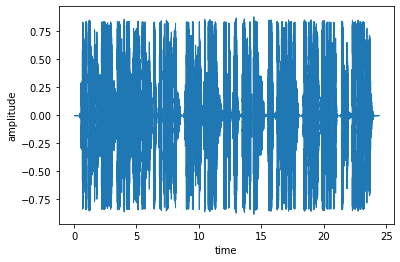

In [15]:
librosa.display.waveshow(signal,sr=sr)
plt.xlabel('time')
plt.ylabel('amplitude')

In [15]:
## power spectrum

In [12]:
fft = np.fft.fft(signal);fft

array([-35.40391737-2.84217094e-14j,  -1.86444274-1.01055805e+01j,
       -14.22389039+1.29566918e+01j, ...,  25.23465432-3.32335885e+00j,
       -14.22389039-1.29566918e+01j,  -1.86444274+1.01055805e+01j])

In [11]:
magnitude = np.abs(fft);magnitude

array([35.40391737, 10.27613277, 19.24045012, ..., 25.45255376,
       19.24045012, 10.27613277])

In [14]:
frequency = np.linspace(0,sr,len(magnitude));frequency

array([0.0000000e+00, 4.1015625e-02, 8.2031250e-02, ..., 2.2049918e+04,
       2.2049959e+04, 2.2050000e+04])

Text(0, 0.5, 'magnitude')

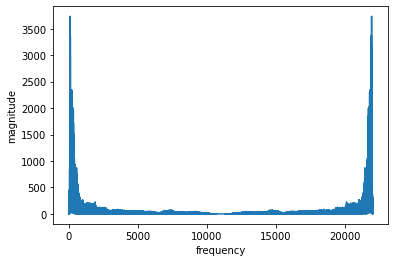

In [18]:
plt.plot(frequency,magnitude)
plt.xlabel('frequency')
plt.ylabel('magnitude')

In [25]:
## a signle fourier transform

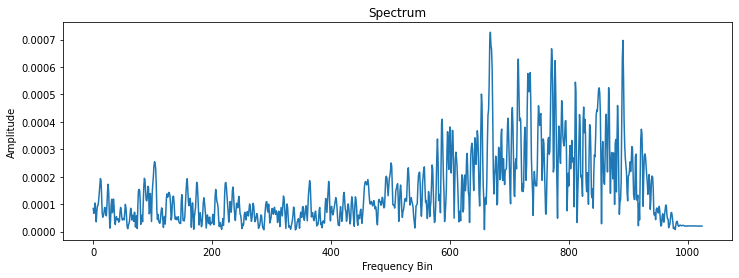

In [46]:
n_fft = 2048
plt.figure(figsize=(12, 4))
ft = np.abs(librosa.stft(signal[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

In [45]:
ft = np.abs(librosa.stft(signal[:n_fft], hop_length =512))

In [26]:
# spectrum show

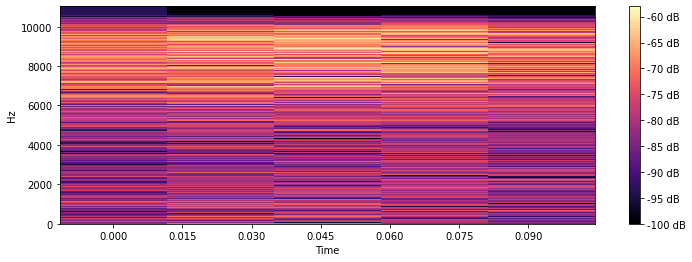

In [44]:
n_fft = 2048
S = librosa.amplitude_to_db(ft)
plt.figure(figsize=(12, 4))
librosa.display.specshow(S, sr=sr, hop_length=512, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.show()

/tmp/ipykernel_87286/555229492.py:2: FutureWarning: Pass y=[-6.01378861e-06 -3.92529455e-06  8.78687842e-06 ... -1.41699511e-05
  1.10003175e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, n_mfcc=13) #computed MFCCs over frames.


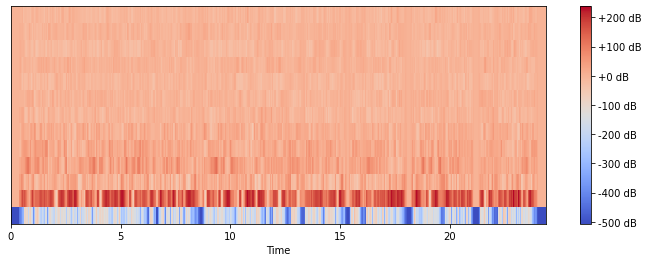

In [35]:
plt.figure(figsize=(12, 4))
mfccs = librosa.feature.mfcc(signal, sr=sr, n_mfcc=13) #computed MFCCs over frames.
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [29]:
# convert to stereo

In [16]:
ifile = wave.open(file)
output = '../data/stereo_amharic.wav'
print(ifile.getparams())
(nchannels, sampwidth, framerate, nframes, comptype, compname) = ifile.getparams()
assert comptype == 'NONE'  # Compressed not supported yet
array_type = {1:'B', 2: 'h', 4: 'l'}[sampwidth]
left_channel = array.array(array_type, ifile.readframes(nframes))[::nchannels]
ifile.close()
stereo = 2 * left_channel
stereo[0::2] = stereo[1::2] = left_channel
ofile = wave.open(output, 'w')
ofile.setparams((2, sampwidth, framerate, nframes, comptype, compname))
try:
    ofile.writeframes(stereo)
    print("succesffully converted to stereo")
except Exception as e:
    print(e)
ofile.close()

_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=1170286, comptype='NONE', compname='not compressed')
succesffully converted to stereo


In [47]:
# mfccs

In [49]:
mfccs = librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=512)

/tmp/ipykernel_87286/527622070.py:1: FutureWarning: Pass y=[-6.01378861e-06 -3.92529455e-06  8.78687842e-06 ... -1.41699511e-05
  1.10003175e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal,n_fft=n_fft,hop_length=512)


Text(0, 0.5, 'mfccs')

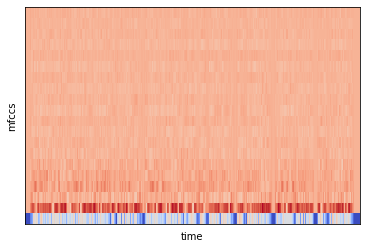

In [52]:
librosa.display.specshow(mfccs,sr=sr,hop_length=512)
plt.xlabel("time")
plt.ylabel("mfccs")

In [8]:
sound_file = AudioSegment.from_wav(file)
audio_chunks = split_on_silence(sound_file, 
    # must be silent for at least half a second
    min_silence_len=500,

    # consider it silent if quieter than -16 dBFS
    silence_thresh=-16
)

for i, chunk in enumerate(audio_chunks):

    out_file = "../data/splitAudio/chunk{0}.wav".format(i)
    chunk.export(out_file, format="wav")

In [10]:
if len(os.listdir('../data/splitAudio/'))==len(text['article'].split(' ')):
    print("this audio is worthy to be pushed to the bucket")
else:
    print("this audio is not worthy to be pushed to the bucket")

this audio is worthy to be pushed to the bucket


# Transforming and Storing into bucket

In [160]:
# let us remove missing values
df_pyspark.show()

+--------------------+--------------------+-----------------+-----+--------------------+--------------------+
|            headline|            category|             date|views|             article|                link|
+--------------------+--------------------+-----------------+-----+--------------------+--------------------+
|የኦሊምፒክ ማጣሪያ ተሳታፊዎ...|                ስፖርት| January 14, 2021|    2|ብርሃን ፈይሳየኢትዮጵያ ቦክ...|https://www.press...|
|          አዲስ ዘመን ድሮ|                መዝናኛ|December 28, 2020|    4| የአዲስ ዘመን ጋዜጣ ቀደም...|                null|
|      መንገድ በመከተል አልፎ|                null|             null| null|                null|                null|
|      አልፎ በሚገኙት ሰፈሮች|                null|             null| null|                null|                null|
|       ብዙዎች የልኳንዳ ሥጋ|                null|             null| null|                null|                null|
|የተሰቀለባቸውና   ፉርኖ ይ...|https://www.press...|             null| null|                null|                null|
|የአረንጓዴ ጎር

In [162]:
match_transcript = df_pyspark.filter(df_pyspark.headline == text['headline'])

In [163]:
match_transcript.show()

+--------------------+--------+---------------+-------+--------------------+--------------------+
|            headline|category|           date|  views|             article|                link|
+--------------------+--------+---------------+-------+--------------------+--------------------+
|ወልዋሎ የአራት ተጫዋቾች ዝ...|    ስፖርት|  March 4, 2020|Unknown|በዝውውር መስኮቱ በርካታ ተ...|https://soccereth...|
|ወልዋሎ የአራት ተጫዋቾች ዝ...|    ስፖርት|August 27, 2019|Unknown|በዝውውሩ በስፋት እየተሳተፉ...|https://soccereth...|
+--------------------+--------+---------------+-------+--------------------+--------------------+



In [165]:
df_with_audio = match_transcript.withColumn("audio",lit(text['id']))

In [166]:
df_with_audio.show()

+--------------------+--------+---------------+-------+--------------------+--------------------+--------------------+
|            headline|category|           date|  views|             article|                link|               audio|
+--------------------+--------+---------------+-------+--------------------+--------------------+--------------------+
|ወልዋሎ የአራት ተጫዋቾች ዝ...|    ስፖርት|  March 4, 2020|Unknown|በዝውውር መስኮቱ በርካታ ተ...|https://soccereth...|a658979e-8642-4fa...|
|ወልዋሎ የአራት ተጫዋቾች ዝ...|    ስፖርት|August 27, 2019|Unknown|በዝውውሩ በስፋት እየተሳተፉ...|https://soccereth...|a658979e-8642-4fa...|
+--------------------+--------+---------------+-------+--------------------+--------------------+--------------------+



# Loading Transformation

In [167]:
df_with_audio.write\
.format("csv")\
.partitionBy("audio")\
.mode("append")\
.save("/mnt/10ac-batch-5/week9/choquet-burhat/groupedByaudio/")

# Schedule Model Update Run

The next thing that we do, is we run some asynchronous tasks in which we publish our new found and validated data to the metadata csv. Then once we have succesfully published the metadata then we go ahead and retrain the model and we have our mlfow log metric ready to tell us whether our model has improved or whether we are wasting our precious time, with this interesting tools for nothing.

In [13]:
!python -m pip install mlflow apache-airflow

In [1]:
import logging
import mlflow
from airflow.decorators import dag,task
import pandas as pd
import os,sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from model_handler import Model

In [6]:
default_args={
    'owner':'martinluther',
    'retries':5,
    'retry_delay':timedelta(minutes=2)
}


In [173]:
@dag(dag_id='dag_for_updating_metadata',
    default_args=default_args,
    start_date=airflow.utils.dates.days_ago(1),
    schedule_interval='@hourly')
def update_metadata():
    @task()
    def run():
        metadata = pd.read_csv('../data/metadata.csv')
        metadata.append({
            'translation':text['article'], 
            'label':text['audio'],
            'channel':0,
            'sample_rate':0,
            'duration':0
        }, ignore_index=True)
    run()

'መስተዳድር'

In [7]:
@dag(dag_id='dag_for_updating_model',
    default_args=default_args,
    start_date=airflow.utils.dates.days_ago(1),
    schedule_interval='@hourly')
def update_model_training_data():
    @task()
    def run():
        with mlflow.start_run(run_name="update_stt_model"):
            
            model = Model(run=True)
            result = model.validate_transcription(
                    ['../data/test_amharic.wav'] , 
                    ["ጠጁን ኰመኰመ ኰመኰመና ሚስቱን ሲያሰቃያት አደረ"])
            mlflow.log_metric("error",result['error'])
    run()

# KAFKA CONNECTION TO AWS (Bonus Tasks)

Another thing we can do is using boto library we can connect to the aws s3 bucket and list whether the data actually reached the s3 bucket or not, Thank you.

In [14]:
!pip install boto3

In [20]:
## let us begin by listing what is inside our buckets in our aws


In [168]:
import boto3

In [169]:
s3 = boto3.resource('s3')
s3_bucket_to_transform =s3.Bucket('10ac-batch-5')

In [170]:
for object_summary in s3_bucket_to_transform.objects.filter(Prefix="week9/choquet-burhat/"):
    print(object_summary.key)

week9/choquet-burhat/
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/FETCH_HEAD
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/HEAD
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/ORIG_HEAD
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/branches/
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/config
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/description
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/hooks/
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/hooks/applypatch-msg.sample
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/hooks/commit-msg.sample
week9/choquet-burhat/An-Amharic-News-Text-classification-Dataset/.git/hooks/fsmonitor-watchman.sa

# Conclusion

So we can conclude, that yes there is a decrease in the word error rate, meaning we truly achieve our purpose. And then another thing, is that we notice that this action takes seconds, therefore this is really awesome, because we get the best of both worlds. If you enjoyed the article please give me a clap. Thank you